# Kernel Principal Component Analysis (KPCA)

In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [272]:
df = pd.read_csv("../data/Diabetes.csv")

# Renaming the columns
column_renames = {
    "Number of times pregnant": "Number_Pregnant",
    "Plasma glucose concentration a 2 hours in an oral glucose tolerance test": "Glucose_Concentration",
    "Diastolic blood pressure (mm Hg)": "Blood_Pressure",
    "Triceps skin fold thickness (mm)": "Skin_Thickness",
    "2-Hour serum insulin (mu U/ml)": "Serum_insulin",
    "Body mass index (weight in kg/(height in m)^2)": "BMI",
    "Diabetes pedigree function": "Diabetes_pedigree_function",
    "Age (years)": "Age",
    "Class variable (0 or 1)": "Diabetes",
}

df = df.rename(columns=column_renames)

# Remove these columns since too many missing entries to perform KPCA on 
df = df.drop(["Serum_insulin"], axis=1)
df = df.drop(["Skin_Thickness"], axis=1)

train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)

train_data = train.drop(["Diabetes"], axis=1).to_numpy()
train_outcome = test["Diabetes"].to_numpy()

test_data = test.drop(["Diabetes"], axis=1).to_numpy()
test_outcome = test["Diabetes"].to_numpy()

# Normilizing data
train_data = (train_data - np.mean(train_data, axis=0)) / np.std(train_data, axis=0)
test_data = (test_data - np.mean(test_data, axis=0)) / np.std(test_data, axis=0)

print(f"Mean of each column: {np.mean(train_data, axis=0)}\n")
print(f"Standard deviation of each column: {np.std(train_data, axis=0)}")

Mean of each column: [ 1.37421742e-17  1.85157716e-16  2.31447145e-16 -2.37233324e-16
 -7.81134115e-17 -1.15723573e-17]

Standard deviation of each column: [1. 1. 1. 1. 1. 1.]


## Calculating the components using KPCA

When calculating the kernel matrix which will be used to find the components, we will be using the gaussian kernel which is defined as $e^{-\gamma\|a-b\|^2}$, where $\gamma$ is a free parameter. The gaussian kernel is the most popular and usually best performing kernel but there are other kernel such as the sigmoid kernel or polynomial kernel.

Formula used to center kernal matrix:

$\bar{K}(x_i, x_j)=K(x_i, x_j) - \frac{1}{d}\displaystyle\sum_{k=1} ^{d} K(x_i, x_k) - \frac{1}{d}\displaystyle\sum_{k=1} ^{d} K(x_i, x_k) - \frac{1}{d^2}\displaystyle\sum_{l,k=1} ^{d} K(x_l, x_k)$

In [273]:
def gaussian_kernel(a, b, gamma):
    return np.exp(-gamma * (np.linalg.norm(a - b) ** 2))

In [274]:
def calculate_kernelPCA(data, n_components=None, gamma=None):
    threshold = 1e-10

    if gamma is None:
        gamma = 1 / data.shape[1]

    # Calculate the kernal metrix using the provided kernel function
    kernel_matrix = np.array([[gaussian_kernel(d1, d2, gamma) for d1 in data] for d2 in data])

    # Centering the kernel matrix
    kernel_matrix = kernel_matrix - np.mean(kernel_matrix, axis=1)[:, np.newaxis] - np.mean(kernel_matrix, axis=0) - np.mean(kernel_matrix)

    # Calculate the eigenvalues and eigenvectors 
    eigenvalues, eigenvectors = np.linalg.eig(kernel_matrix)

    # Sort the eigenvalues and eigenvectors based on the values of the eigenvalue
    sorted_indices = np.argsort(eigenvalues)[::-1]
    lambdas = eigenvalues[sorted_indices]
    alphas = eigenvectors[:, sorted_indices]

    # Remove eigenvalues and eigenvectors where the eigenvalue is less than the threshold
    lambdas = lambdas[lambdas > threshold]
    alphas = alphas[:, :lambdas.shape[0]]
    
    if n_components is None:
        n_components = lambdas.shape[0]
    else:
        n_components = min(lambdas.shape[0], n_components)

    return alphas.real[:, :n_components], lambdas.real[:n_components]

In [275]:
alphas, lambdas = calculate_kernelPCA(train_data, n_components=2)

In [276]:
def project_data(data_point, data, alphas, gamma=None):
    if gamma is None:
        gamma = 1 / data.shape[1]
    
    return np.array([np.sum([
        alpha[i] * gaussian_kernel(data_point, data[i], gamma) for i in range(data.shape[0])
    ]) for alpha in alphas.T])

In [277]:
projected_data_points = np.array([
    project_data(data_point, train_data, alphas) for data_point in test_data
])

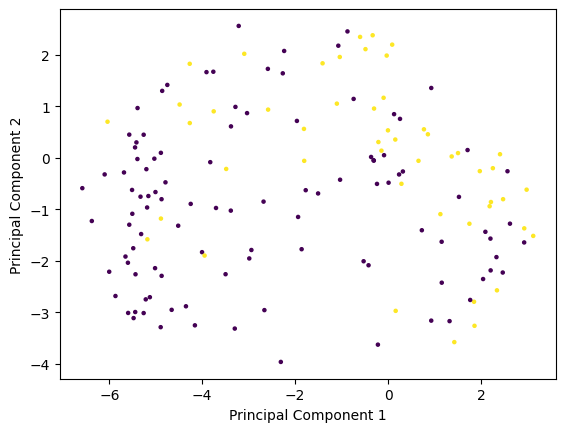

In [278]:
plt.xlabel(f"Principal Component 1")
plt.ylabel(f"Principal Component 2")
plt.scatter(projected_data_points[:, 0], projected_data_points[:, 1], c=test_outcome, s=5)
plt.show()